In [11]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample

# This script uses the export summary created by the OrchestraZ auto export application feature
#  to analyze the data


In [12]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/"
export_summary = data_dir + "export_summary-both.csv"

data_dir_nbqx = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/"
nbqx_export_summary = data_dir_nbqx + "export_summary-nbqx-only.csv"

rand_data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/"
rand_export_summary = rand_data_dir + "export_summary-rand.csv"

camera_program = 4
um_per_px = 6.0 #um

In [13]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

# open export summary csv
df_both = pd.read_csv(export_summary)
df_nbqx = pd.read_csv(nbqx_export_summary)
df_rand = pd.read_csv(rand_export_summary)

# normalize latency
actual_stim_time = 48.9
df_both['latency'] = df_both['latency'] - actual_stim_time
df_nbqx['latency'] = df_nbqx['latency'] - actual_stim_time
df_rand['latency'] = df_rand['latency'] - actual_stim_time

# divide amp by 1000
df_both['amp'] = df_both['amp'] / 1000
df_nbqx['amp'] = df_nbqx['amp'] / 1000
df_rand['amp'] = df_rand['amp'] / 1000

df_both

,ROI,amp,snr,latency,halfwidth,Stim_Distance,ROI_Set,Date,Slice,Location,Recording,trace,Unnamed: 12
0,1.0,0.003171,39.36250,1.0686,9.03713,20.66053,1.928134,7/15/2024,2.0,1.0,1.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
1,2.0,0.003885,50.35280,2.4901,11.62340,10.71530,NaN,7/15/2024,2.0,1.0,1.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
2,1.0,0.006082,62.17320,0.8746,5.56389,NaN,NaN,7/15/2024,2.0,1.0,3.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
3,2.0,0.006548,59.75340,2.2873,4.81987,NaN,NaN,7/15/2024,2.0,1.0,3.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
4,1.0,0.009305,84.64130,0.8554,5.67852,NaN,NaN,7/15/2024,2.0,1.0,5.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
5,2.0,0.009700,80.91630,2.2481,5.03678,NaN,NaN,7/15/2024,2.0,1.0,5.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
6,1.0,0.007436,40.48660,2.6353,10.16720,NaN,NaN,7/17/2024,3.0,1.0,1.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
7,2.0,0.008700,42.83210,2.7089,6.29783,NaN,NaN,7/17/2024,3.0,1.0,1.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
8,1.0,0.010396,49.02190,2.4900,9.54256,NaN,NaN,7/17/2024,3.0,1.0,4.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN
9,2.0,0.006582,26.92820,3.0780,9.66218,NaN,NaN,7/17/2024,3.0,1.0,4.0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN


C:/Users/jjudge3/Desktop/Data/full archive-anna/07-17-24/converted_zda/3_1_1_trace.dat


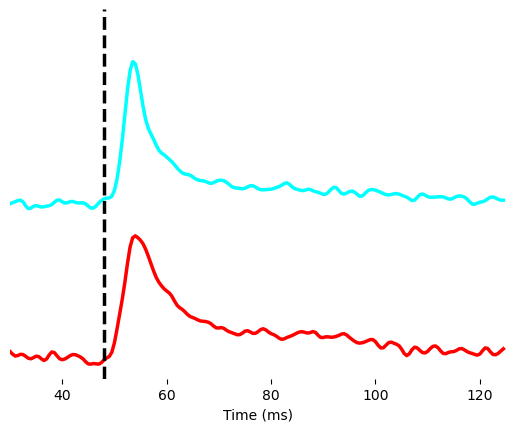

C:/Users/jjudge3/Desktop/Data/full archive-anna/07-17-24/converted_zda/3_1_2_trace.dat


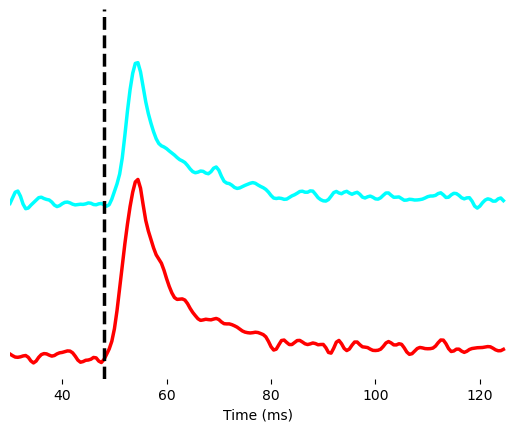

C:/Users/jjudge3/Desktop/Data/full archive-anna/07-17-24/converted_zda/3_1_5_trace.dat


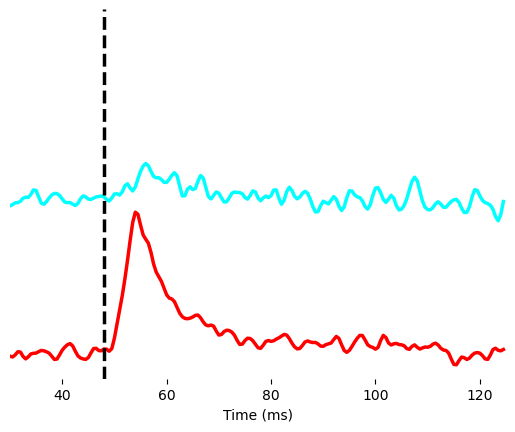

In [26]:
control_trace = "C:/Users/jjudge3/Desktop/Data/full archive-anna/07-17-24/converted_zda/3_1_1_trace.dat"
mid_trace = "C:/Users/jjudge3/Desktop/Data/full archive-anna/07-17-24/converted_zda/3_1_2_trace.dat"
nbqx_trace = "C:/Users/jjudge3/Desktop/Data/full archive-anna/07-17-24/converted_zda/3_1_5_trace.dat"
for trace_file in [control_trace, mid_trace, nbqx_trace]:
    try:
        trace = read_traces_file(trace_file)
    except FileNotFoundError:
        print("File not found:")
        continue
    print(trace_file)

    tm = TraceMetrics(trace)
    tm.show_traces(measure_window=[60, 250], 
            legend=False, 
            colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                    'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
            stim_time=48,#actual_stim_time+100,
            headroom=9,
            ylim=[-1.5, 20.5],
            save_path='P:/John/crossing-paper/input/trace_plots_' + os.path.basename(trace_file).split('.')[0] + '.png'
                    )


In [15]:
# plot traces
for i, df in enumerate([df_both]): # , df_nbqx, df_rand]):
    n_plots = 4
    print(['both', 'nbqx', 'rand'][i])
    for date in df['Date'].unique():
        df_date = df[df['Date'] == date]
        for slic_id in df_date['Slice'].unique():
            df_slic = df_date[df_date['Slice'] == slic_id]
            for loc_id in df_slic['Location'].unique():
                df_loc = df_slic[df_slic['Location'] == loc_id]
                for rec_id in df_loc['Recording'].unique():
                    df_rec = df_loc[df_loc['Recording'] == rec_id]


                    if n_plots == 0:
                        continue

                    # trace filename
                    trace_filename = df_rec['trace'].values[0]
                    try:
                        trace = read_traces_file(trace_filename)
                    except FileNotFoundError:
                        print("File not found:")
                        continue
                    print(trace_filename)

                    tm = TraceMetrics(trace)
                    print(date, slic_id, loc_id, rec_id)
                    tm.show_traces(measure_window=[10, 740], 
                            legend=False, 
                            colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                    'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                            stim_time=None,#actual_stim_time+100,
                            headroom=3,
                                    )
                    n_plots -= 1
                    
                    """tm.frequency_decomposition(measure_window=[94, 140],
                                                    xlim=[20, 400])"""

both
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:
File not found:


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighb

7/15/2024 1 [2.] [5.] Both
7/17/2024 1 [2.] [5.] Both
7/25/2024 1 [3.] [6.] Both
7/24/2024 1 [2.] [6.] Both
6/14/2024 2 [2 3] [4 4] NBQX
6/14/2024 2 [2 3] [5 5] NBQX
6/26/2024 1 [2] [3] NBQX
6/26/2024 1 [2] [4] NBQX
7/1/2024 2 [2 3] [4 4] NBQX
7/1/2024 2 [2 3] [5 5] NBQX


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_23008\67235853.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neighb

7/1/2024 1 [2] [3] NBQX
7/1/2024 1 [2] [4] NBQX
7/5/2024 1 [2] [3] NBQX
7/5/2024 2 [2 3] [2 2] NBQX
7/5/2024 1 [3] [3] NBQX
latency None mean 2.466169230769231 +/- 0.25752151052415606 Drug mean 3.167835000000001 +/- 0.2883917559661
halfwidth None mean 15.913245384615387 +/- 2.473289216558204 Drug mean 11.0678165 +/- 1.6769036240361006
amp None mean 0.002467810384615385 +/- 0.0007931501073478409 Drug mean 0.0030096797 +/- 0.0007476709213444145


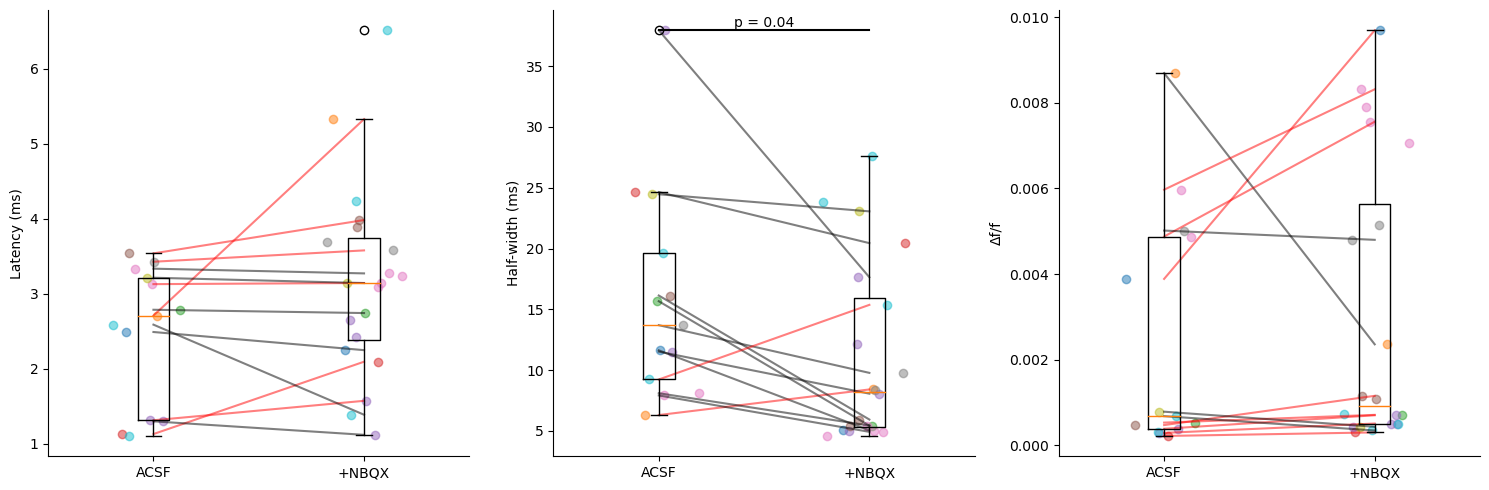

In [17]:
# plot distributions of latency, half-width, and amplitude of neightboring barrels
# divided by 

# catalog df
catalog_df = pd.read_csv("C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/trial_df_edit.csv")


distributions_none = {'latency': [], 'halfwidth': [], 'amp': []}
distributions_drug = {'latency': [], 'halfwidth': [], 'amp': []}
recording_pairs = {'latency': {}, 'halfwidth': {}, 'amp': {}}

df_list = [df_both, df_nbqx]
#df_list = [df_rand]
file_out_name = "rand" if len(df_list) == 1 else "barrels"

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
i_color = -1

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i_drug, drug_df in enumerate(df_list):
    neighbor_df = drug_df[drug_df['ROI'] != 1]
    # exclude 7/25/24 ROI 2 (dependent measurement with ROI 3 from same recordings) -- drop rows from neighbor_df
    neighbor_df = neighbor_df.drop(neighbor_df[(neighbor_df['ROI'] == 2) & (neighbor_df['Date'] == '7/25/2024')].index)

    # latency, halfwidth, and amplitude must be positive
    neighbor_df = neighbor_df[(neighbor_df['latency'] > 0) & 
                              (neighbor_df['latency'] < 20) & 
                              (neighbor_df['halfwidth'] > 0) & 
                              (neighbor_df['amp'] > 0)]

    for date in neighbor_df['Date'].unique():
        date_df = neighbor_df[neighbor_df['Date'] == date]
        for slic_id in date_df['Slice'].unique():
            slic_df = date_df[date_df['Slice'] == slic_id]
            for loc_id in slic_df['Location'].unique():
                loc_df = slic_df[slic_df['Location'] == loc_id]
                i_color = (i_color + 1) % len(colors)
                for rec_id in loc_df['Recording'].unique():

                    catalog_formatted_date = date.replace('-', '/')
                    if len(catalog_formatted_date.split("/")[-1]) < 4:
                        catalog_formatted_date = catalog_formatted_date[:-2] + '20' + catalog_formatted_date[-2:]

                    # get the corresponding catalog entry
                    catalog_entry = catalog_df[(catalog_df['Date'] == catalog_formatted_date) & 
                                                (catalog_df['Slice#'] == slic_id) & 
                                                (catalog_df['Location'] == loc_id) & 
                                                (catalog_df['Recording'] == rec_id)]
                    neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
                    if len(catalog_entry) == 0:
                        print("No catalog entry for", catalog_formatted_date, slic_id, loc_id, rec_id)
                        continue
                    drug = catalog_entry['Drug'].values[0]
                    is_steady_state = catalog_entry['steady_state'].values[0]

                    if drug == 'None' or (i_drug == 0 and drug == 'Both') or (i_drug == 1 and drug == 'NBQX' and is_steady_state == 'y'):
                        # plot latency, hlaf-width, and amplitude in the corresponding plot (ACSF or both)
                        i_x = 0 if drug == 'None' else 1
                        if drug != 'None':
                            print(neighbor_df_subset['Date'].values[0], len(neighbor_df_subset), neighbor_df_subset['ROI'].values, neighbor_df_subset['Recording'].values, drug)
                        for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):

                            # halfwidth and latency must be positive
                            if metric == 'halfwidth' or metric == 'latency':
                                neighbor_df_subset = neighbor_df_subset[neighbor_df_subset[metric] > 0]

                            # plot 7/15/2024 amplitude in black
                            color = colors[i_color]

                            x_jitter = np.random.normal(0, 0.1, len(neighbor_df_subset))

                            if len(neighbor_df_subset) > 0:
                                ax[i_plot].scatter(i_x + x_jitter, neighbor_df_subset[metric], alpha=0.5, c=color)
                                ax[i_plot].set_xticks([0, 1])
                                ax[i_plot].set_ylabel(metric)

                                # add to distribution
                                if drug == 'None':
                                    distributions_none[metric].extend(neighbor_df_subset[metric].values)
                                else:
                                    distributions_drug[metric].extend(neighbor_df_subset[metric].values)

                                # add to recording pairs

                                if date + str(slic_id) + str(loc_id) not in recording_pairs[metric]:
                                    recording_pairs[metric][date + str(slic_id) + str(loc_id)] = {}
                                recording_pairs[metric][date + str(slic_id) + str(loc_id)][drug] = neighbor_df_subset[metric].values

# plot lines between pairs of recordings
for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):
    for recording_pair in recording_pairs[metric].values():
        if 'None' in recording_pair and 'NBQX' in recording_pair:
            for i_roi in range(len(recording_pair['None'])):
                if i_roi >= len(recording_pair['NBQX']):
                    continue
                color = 'r-' if recording_pair['None'][i_roi] < recording_pair['NBQX'][i_roi] else 'k-'
                ax[i_plot].plot([0, 1], [recording_pair['None'][i_roi], recording_pair['NBQX'][i_roi]], color, alpha=0.5)  
        if 'None' in recording_pair and 'Both' in recording_pair:
            for i_roi in range(len(recording_pair['None'])):
                if i_roi >= len(recording_pair['Both']):
                    continue
                color = 'r-' if recording_pair['None'][i_roi] < recording_pair['Both'][i_roi] else 'k-'
                ax[i_plot].plot([0, 1], [recording_pair['None'][i_roi], recording_pair['Both'][i_roi]], color, alpha=0.5)


# plot distributions as boxplots over the existing scatter plots
for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):
    ax[i_plot].boxplot([distributions_none[metric], distributions_drug[metric]], positions=[0, 1])
    print(metric, 'None mean', np.mean(distributions_none[metric]), "+/-", sem(distributions_none[metric]),
          'Drug mean', np.mean(distributions_drug[metric]), "+/-", sem(distributions_drug[metric]))
    ax[i_plot].set_xticks([0, 1])
    ax[i_plot].set_xticklabels(['ACSF', '+NBQX'])
    ax[i_plot].set_ylabel({'latency': 'Latency (ms)', 'halfwidth': 'Half-width (ms)', 'amp': 'Δf/f'}[metric])

# turn off spines
for i_plot in range(3):
    ax[i_plot].spines['top'].set_visible(False)
    ax[i_plot].spines['right'].set_visible(False)


# conduct significance tests (Welch's t-test, one-sided)
for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):
    '''print(metric)
    t_stat, pval = ttest_ind(distributions_none[metric], distributions_drug[metric], equal_var=False, alternative='less')
    pval = min(pval, 1- pval)  # some one-sided tests are greater, some are lesser. Automatically choose the smaller p-value
    print(t_stat, 'pval', pval)'''

    # p-vals from barrel averages:
    pval = [0.0506, 0.04, 0.290][i_plot]

    if pval < 0.05:
        # plot significance line
        ax[i_plot].plot([0, 1], [np.max([np.max(distributions_none[metric]), np.max(distributions_drug[metric])])]*2, 'k-')
        ax[i_plot].text(0.5, np.max([np.max(distributions_none[metric]), np.max(distributions_drug[metric])]), 'p = ' + str(pval)[:4], ha='center', va='bottom')

# increase space between subplots
plt.tight_layout()
plt.savefig("P:/John/crossing-paper/input/output-drug-compare" + file_out_name + ".png")
plt.show()

In [ ]:
# now generate either random barrel samples or striped barrel ROIs to extract latency
# create random ROI samples of 1 pixel, or stripes of 5 pixel width. Stripes parallel to barrel axis
# Generate ROI files of specified sizes
roi_type = "random"  # set to "stripes" or "random"

lock_roi = True  # set to True to lock in ROIs, as safeguard to avoid overwriting

data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/AnnaW-blockade/combined-nbqx-both/"
roi_sampler = RandomROISample(1)
data_file_map = {}
distance_map = {}
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if 'roi.dat' in file:

            # load barrel file (lists of lists of diode numbers)
            barrel_rois = ROIFileReader(subdir + '/' + file).get_roi_list()

            # convert from diode to pixel
            barrel_rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in barrel_rois]
            
            
            brc = Barrel_ROI_Creator(max_rois=40)
            new_rois = None

            if roi_type == "random" and not lock_roi:
                new_rois = brc.get_rand_rois(barrel_rois)  # default: 1 px per ROI, 100 ROIs per barrel

                # convert pixels to diode numbers
                roi_cr = ROICreator(None)
                for k in new_rois:
                    new_rois[k] = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois[k]]

            # write each new ROI to a separate file
            rfw = ROIFileWriter()
            selected_zda_dir = subdir 
            subdir_shortened = subdir.split('\\selected_zda')[0]
            if subdir_shortened not in data_file_map:
                data_file_map[subdir_shortened] = {}
            data_file_map[subdir_shortened][file] = []
            for barrel_idx in new_rois:
                roi_file = brc.get_rand_roi_filename(selected_zda_dir, barrel_idx, file)
                if roi_type == "stripes":
                    roi_file = brc.get_stripe_roi_filename(selected_zda_dir, barrel_idx, file)
                if not lock_roi:
                    rfw.write_regions_to_dat(roi_file, new_rois[barrel_idx])
                    print("Wrote", roi_file)
                data_file_map[subdir_shortened][file].append(roi_file)

TypeError: 'NoneType' object is not iterable

## 